# Árboles de decisión 

## Introducción

Un árbol de decisión es una secuencia de operadores relacionales organizados como árbol donde:

- Los atributos de un dato son evaluados desde la raiz hasta las hojas
- Los nodos hoja (terminales) están asociados a una clase
- Los nodos no-hoja están asociados a un operador lógico que divide los datos en dos o más conjuntos
- El operador lógico o *split* se aplica sobre un atributo (feature) de los datos

El siguiente diagrama ejemplifica el funcionamiento del árbol de decisión sobre un dataset con dos etiquetas y dos atributos (X y Z). 

<img src="img/dt_diagram.png" width="600">

- La figura izquierda muestra un árbol de decisión binario con 5 nodos: 3 nodos hoja y 2 nodos de decisión.
- La figura derecha muestra la partición que produce el árbol de decisión en el espacio de los datos. 
- Las separaciones o *splits* son siempre perpendiculares a los ejes de los datos (atributos).

:::{important}

Entrenar el árbol de decisión es el proceso de escoger los atributos, operadores y umbrales de separación en los nodos de decisión.

:::

A continuación veremos los algoritmos que se han desarrollado para entrenar árboles de decisión.

## Algoritmo Iterative Dichotomiser 3 (ID3)

El algoritmo ID3 para atributos categóricos selecciona los *splits* recursivamente en base a la **ganancia de información**.

La ganacia de información para un nodo que separa un conjunto de datos $D$ en dos $D_{izq}$ y $D_{der}$ es

$$
G(D; D_{izq}, D_{der}) = H(D) - \frac{|D_{izq}|}{|D|} H(D_{izq}) - \frac{|D_{der}|}{|D|} H(D_{der})
$$

donde $|A|$ es la cardinalidad del subconjunto $A$ y 

$$
H(A) = - \sum_{y \in \mathcal{Y}} p(y|A) \log p(y|A)
$$

es la entropía del subconjunto $A$. En la expresión anterior $p(y|A)$ es la frecuencia relativa de los ejemplos de clase $y$ dentro de $A$.

:::{note}

La entropía mide la "pureza" del subconjunto en términos de sus clases. El subconjunto más puro es aquel donde todos los elementos son de la misma clase. El nodo más impuro es aquel en donde hay igual cantidad de elementos de cada clase (uniforme).

:::

**Ejemplo:** Sea el siguiente arreglo las etiquetas de un subconjunto de 12 ejemplos

In [1]:
import numpy as np

labels = np.array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1])

Asumiendo que el problema sólo tiene dos clases las frecuencias relativas son

In [2]:
_, counts = np.unique(labels, return_counts=True)
counts/len(labels)

array([0.33333333, 0.66666667])

Y la entropía del conjunto sería:

In [3]:
def entropy(subset_labels):
    unique, counts = np.unique(subset_labels, return_counts=True)
    frequencies = counts/len(subset_labels)
    return -np.sum(frequencies*np.log2(frequencies+1e-16))

entropy(labels)

0.9182958340544893

La entropía es máxima si hay igual cantidad de ejemplos de ambas clases (mínima pureza)

In [4]:
B = np.array([1, 1, 1, 0, 0, 0])
entropy(B)

0.9999999999999997

y mínima si todos los ejemplos son de una clase  (máxima pureza)

In [5]:
C = np.array([1, 1, 1, 1, 1, 1])
entropy(C)

-0.0

**Extensión a más de dos clases**

Si un nodo separa el conjunto en $k$ subconjuntos la regla es

$$
G(D; D_1, D_2, \ldots D_k) = H(D) - \sum_{i=1}^k \frac{|D_i|}{|D|} H(D_i)
$$


:::{note}

En cada nodo se escoge el atributo que maximiza la ganancia de información.

:::

Consideremos el siguiente problema:

In [6]:
import pandas as pd

data = {'tiempo': ['soleado', 'soleado', 'soleado', 'lluvioso', 'lluvioso'], 
        'humedad': ['baja', 'baja', 'alta', 'alta', 'alta'],
        'temperatura': ['templado', 'caluroso', 'caluroso', 'templado', 'frio']}

node = pd.DataFrame(data)
node

,tiempo,humedad,temperatura
0,soleado,baja,templado
1,soleado,baja,caluroso
2,soleado,alta,caluroso
3,lluvioso,alta,templado
4,lluvioso,alta,frio


donde queremos obtener un árbol de decisión que prediga el tiempo en función de la humedad y de la temperatura.

Para decidir cual variable debe ir en el primer nodo comparamos sus ganancias de información

In [7]:
def info_gain(subset, feature):
    subset_labels = subset["tiempo"].values
    entropy_root = entropy(subset_labels)
    entropy_nodes = []
    for unique_label in subset[feature].unique():
        split = subset.loc[subset[feature] == unique_label]
        split_labels = split["tiempo"].values
        entropy_nodes.append(entropy(split_labels)*len(split_labels)/len(subset_labels))
    return entropy_root - sum(entropy_nodes)


for feature in ["humedad", "temperatura"]:
    print(f"Ganancia de información de {feature}: {info_gain(node, feature):0.6f}")

Ganancia de información de humedad: 0.419973
Ganancia de información de temperatura: 0.570951


Temperatura tiene mayor ganancia que humedad, por lo tanto el primer nodo separador utiliza temperatura.

Si separamos por temperatura tenemos:

In [8]:
node.loc[node["temperatura"] == 'frio']

,tiempo,humedad,temperatura
4,lluvioso,alta,frio


En el caso `frio` se produce un nodo con un sólo ejemplo. El algoritmo no seguirá dividiendo.

In [9]:
node.loc[node["temperatura"] == 'caluroso']

,tiempo,humedad,temperatura
1,soleado,baja,caluroso
2,soleado,alta,caluroso


En el caso `caluroso` se produce un nodo con "puro". El algoritmo no seguirá dividiendo.

In [10]:
node.loc[node["temperatura"] == 'templado']

,tiempo,humedad,temperatura
0,soleado,baja,templado
3,lluvioso,alta,templado


En el caso `templado` el nodo no es puro, debemos nuevamente escoger un atributo para separar:

In [11]:
node = node.loc[node["temperatura"] == 'templado']
for feature in ["humedad", "temperatura"]:
    print(f"Ganancia de información de {feature}: {info_gain(node, feature)}")

Ganancia de información de humedad: 0.9999999999999997
Ganancia de información de temperatura: 0.0


Por lo tanto se escoge humedad, lo cual produce dos nodos puros (con un sólo ejemplo)

In [12]:
node.loc[node["humedad"] == 'baja']

,tiempo,humedad,temperatura
0,soleado,baja,templado


In [13]:
node.loc[node["humedad"] == 'alta']

,tiempo,humedad,temperatura
3,lluvioso,alta,templado


:::{important}

El algoritmo ID3 sigue separando el dataset de forma recursiva hasta que todos los nodos sean puros o hasta que se supere una profundidad máxima previamente designada.

:::

## Algoritmos C4.5 y CART

El algoritmo C4.5 extiende ID3 para manejar atributos continuos. 

Sea $Y$ un atributo continuo para un nodo con $N$ ejemplos. Primero se ordena $Y$ de menor a mayor y luego  se prueban $N-1$ umbrales $z_i = (\hat y_{i+1} + \hat y_i)$, donde $\hat y$ son los valores ordenados de $y$.

Se escoge el umbral $\hat z$ con mayor ganancia de información y se dividen los datos en dos grupos según:

- $Y \leq \hat z$
- $Y > \hat z$


El algoritmo CART extiende aun más C4.5 permitiendo crear árboles para variables objetivo continuas (regresión). Para esto se reemplaza la entropía en la ganancia de información por el índice de Gini:

$$
I(D) = 1 - \sum_{y\in \mathcal{Y}} p_y^2
$$

donde $p_y$ es la probabilidad asignada a la clase $y$.

:::{note}

La diferencia en clasificación entre el índice de gini y la entropía suele ser muy baja. Sin embargo el índice de gini es menos costoso (computacionalmente hablando). El criterio de ganancia de información (gini o entropia) puede seleccionarse como cualquier otro hiperparámetro mediante validación cruzada.

:::

## Implementación en scikit-learn

El módulo [`tree`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) de scikit-learn tiene implementaciones de árboles de decisión para problemas de clasificación y regresión. Nos enfocaremos en la primera.

Los principales argumentos de [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) son:

- `criterion`: El criterio que se utiliza para escoger los *splits*, las opciones son `'gini'` y `'entropy'`
- `max_depth`: Límite para la profundidad máxima del árbol
- `min_samples_split`: El número mínimo de ejemplos en un nodo para realizar un *split*
- `min_samples_leaf`: El número mínimo de ejemplos que pueden estar en un nodo hoja
- `min_impurity_decrease`: La disminución de pureza mínima en un nodo para realizar un *split*
- `class_weight`: Permite asignar ponderación a las clases, es de utilidad si se tienen clases medianamente desbalanceadas
- `max_features`: El número máximo de atributos a considerar en cada *split*

:::{caution}

Si se utilizan los argumentos (hiperparámetros) por defecto el árbol crecera hasta que sus nodos sean todos puros. Esto en general produce árboles de gran profundidad (muy capaces de sobreajustarse). 

:::

:::{note}

Se puede limitar el tamaño de un árbol aumentando `min_samples_leaf` y/o `min_samples_split`, o disminuyendo `max_depth`.

:::

Los principales métodos son:

- `predict(X)`: Retorna la clase predicha
- `predict_proba(X)`: Retorna las probabilidades de pertenecer a cada una de las clases
- `score(X,y)`: Retorna el *accuracy* de clasificación
- `get_params()`: Retorna los nombres de los parámetros

Además tiene algunos métodos no compartidos con otros estimadores como

- `get_depth()`: Retorna la profunidad del árbol aprendido
- `get_n_leaves()`: Retorna la cantidad de nodos hoja del árbol aprendida
- `apply(X)`: Retorna el índice de la hoja que predice cada ejemplo



**Ejemplo:** A continuación entrenaremos un árbol de decisión sobre [`wine`](https://archive.ics.uci.edu/ml/datasets/wine), una base de datos con 13 atributos numéricos y 3 clases asociadas a vinos de distinto origen. Los atributos representan propiedades químicas de los vinos

In [14]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

data_struct = load_wine()
X = data_struct.data
y = data_struct.target
X_names = data_struct.feature_names

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)

:::{note}

Los árboles de decisión no son sensibles a la normalización de los datos. En general no es necesario normalizar o escalar los datos antes de entrenar un árbol de decisión.

:::

En primer lugar se entrena un árbol de decisión con sus parámetros por defecto

In [15]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

La profundidad del árbol entrenado es:

In [16]:
model.get_depth()

4

El *accuracy* del modelo en el conjunto de test es:

In [17]:
model.score(X_test, y_test)

0.9629629629629629

Podemos utilizar la función [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree) para obtener una visualización del árbol de decisión. En cada nodo se muestra:

- El atributo y umbral seleccionados.
- El valor del criterio (índice de gini).
- La cantidad de ejemplos que entraron al nodo.
- La cantidad de ejemplos que entraron al nodo separados por clase (en este caso tres).


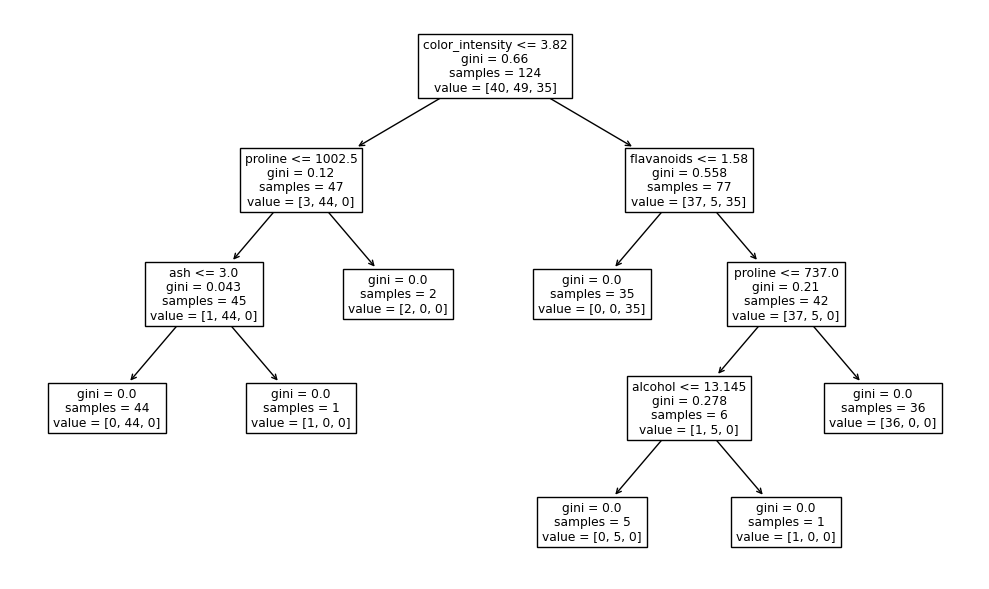

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
plot_tree(model, feature_names=X_names, ax=ax);

:::{note}

El árbol por defecto crece hasta que todos sus nodos sean puros.

:::

Podemos limitar el tamaño de un árbol utilizando el argumento `max_depth`:

Test accuracy: 0.9444


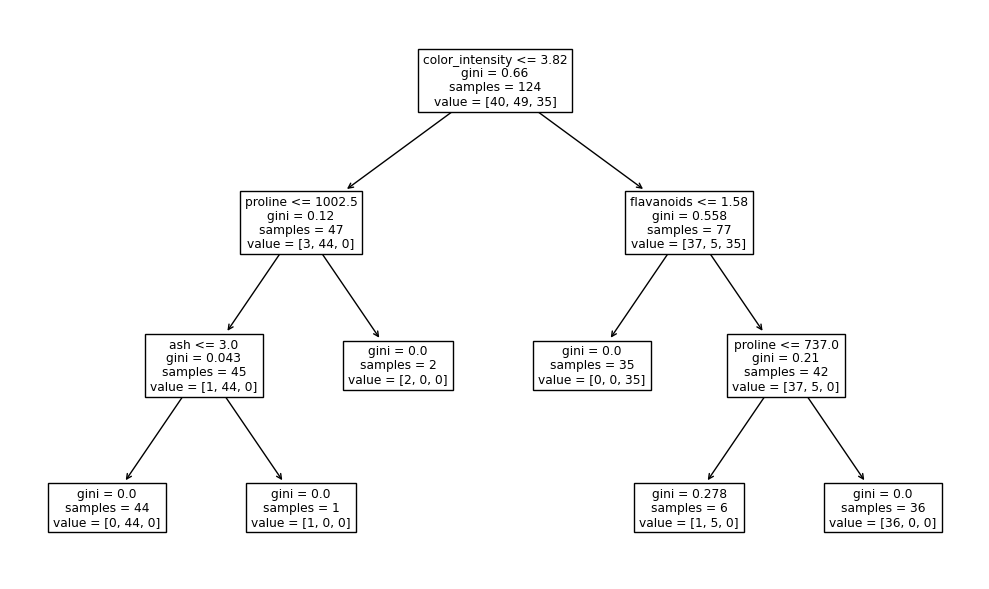

In [19]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)
print(f"Test accuracy: {model.score(X_test, y_test):0.4f}")

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
plot_tree(model, feature_names=X_names, ax=ax);

o el argumento `min_samples_leaf`:

Test accuracy: 0.9444


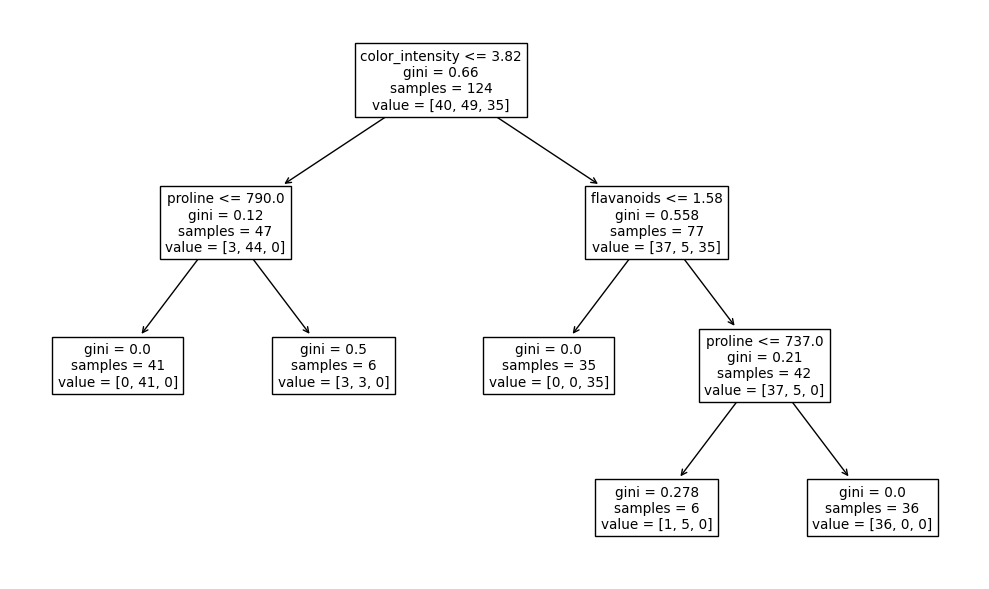

In [20]:
model = DecisionTreeClassifier(min_samples_leaf=5)
model.fit(X_train, y_train)
print(f"Test accuracy: {model.score(X_test, y_test):0.4f}")

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
plot_tree(model, feature_names=X_names, ax=ax);

:::{note}
            
Forzar una profundidad con `max_depth` tiende a producir árboles simétricos. Los árboles restringidos con `min_samples_leaf` pueden ser resultar en cambio asímetricos

:::

Realicemos ahora una búsqueda de hiperparámetros con validación cruzada

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {'criterion': ['entropy', 'gini'], 
          'max_depth': [1, 2, 3, 4, 5, 10, 20, None],
          'min_samples_leaf': [1, 2, 5, 10, 20],
          }

model = DecisionTreeClassifier()
validator = GridSearchCV(model, params, cv=3, refit=True)
validator.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 10, 20, None],
                         'min_samples_leaf': [1, 2, 5, 10, 20]})

Los mejores modelos de acuerdo a la validación cruzada son:

In [22]:
import pandas as pd
columns = ["param_criterion", "param_max_depth", "param_min_samples_leaf",
           "mean_test_score", "std_test_score", "rank_test_score"]
pd.DataFrame(validator.cv_results_)[columns].sort_values(by="rank_test_score").head(5)

,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score,std_test_score,rank_test_score
76,gini,None,2,0.911537,0.029399,1
60,gini,5,1,0.911537,0.029399,1
71,gini,20,2,0.911537,0.029399,1
55,gini,4,1,0.903407,0.018742,4
75,gini,None,1,0.903407,0.018742,4


El mejor árbol de decisión para este problema es:

In [23]:
validator.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}

El resultado del mejor árbol en el conjunto de prueba en términos de f1-score por clase es:

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, validator.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.91      0.95      0.93        22
           2       0.93      1.00      0.96        13

    accuracy                           0.94        54
   macro avg       0.95      0.95      0.95        54
weighted avg       0.95      0.94      0.94        54



También podemos utilizar [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn-metrics-confusionmatrixdisplay) para desplegar una matriz de confusión y así estudiar de mejor forma los errores que cometé el modelo en el conjunto de prueba.

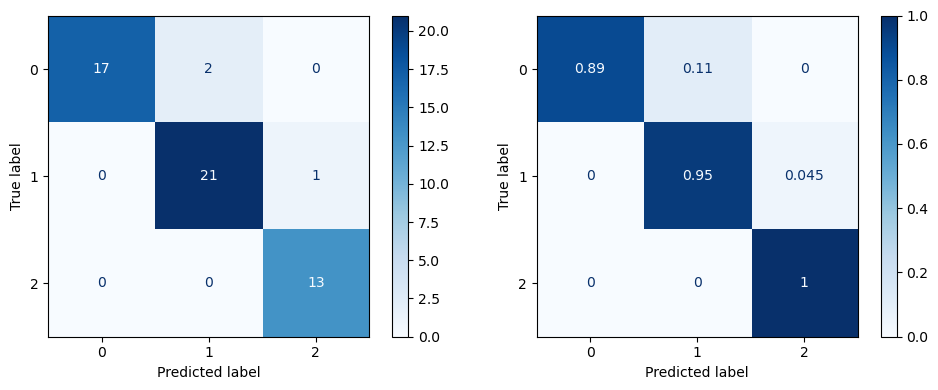

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

ConfusionMatrixDisplay.from_predictions(y_test, validator.predict(X_test), normalize=None,
                                        ax=ax[0], cmap='Blues', colorbar=True);

ConfusionMatrixDisplay.from_predictions(y_test, validator.predict(X_test), normalize='true',
                                        ax=ax[1], cmap='Blues', colorbar=True);

:::{note}

La matriz de la izquierda utiliza cantidades absolutas, mientras que la derecha utiliza cantidades relativas, con respecto a la cantidad de etiquetas reales. 

:::